In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy


## Loading config files, setup execution parameters, init objects

In [35]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 0.3},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 2,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'batch_size': 1024,
                  'learning_rate': 0.001,
                  'loss_fn': 'mse',
                  'num_epochs': 15,
                  'optimizer': 'adam',
                  'reduction': 'sum'}}


# Set parameters

In [36]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-04-29_18:02:50.log]


## Init data loader and get appropriate part of data

using 0.3 of data
X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)
Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (6923, 1)
output partition shape (6923, 1)
stacked Y shape  (6795, 3)
Y_tensor torch.Size([6795, 3])
X_tensor torch.Size([128, 6794, 1])
X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)
Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (16154, 1)
output partition shape (16154, 1)
stacked Y shape  (16026, 3)
Y_tensor torch.Size([16026, 3])
X_tensor torch.Size([128, 16025, 1])
train set: [16026] batches
test set: [6795] batches
data_loading time 22.575849056243896 secs


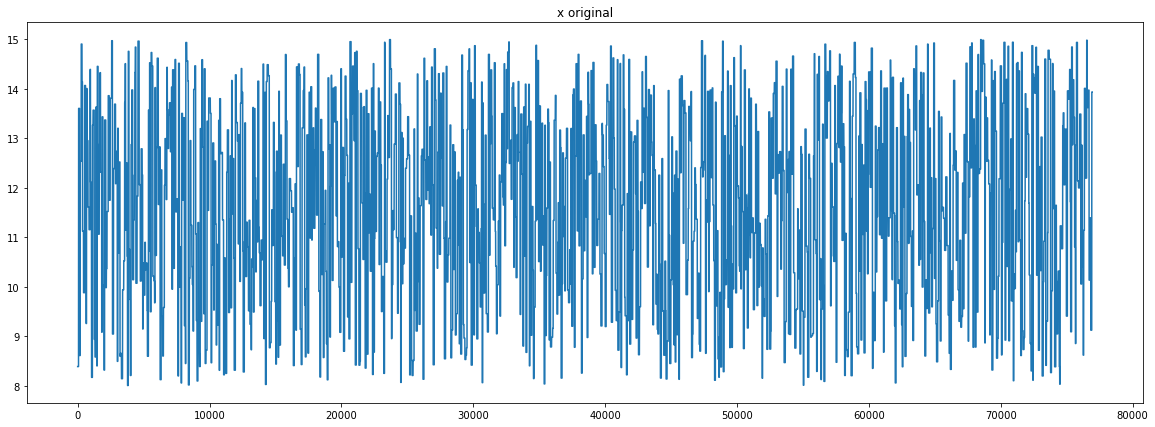

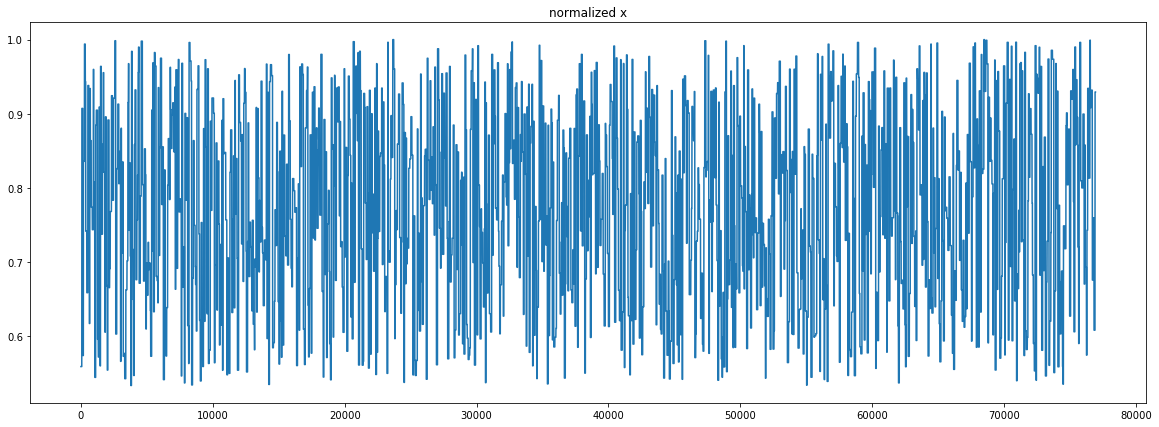

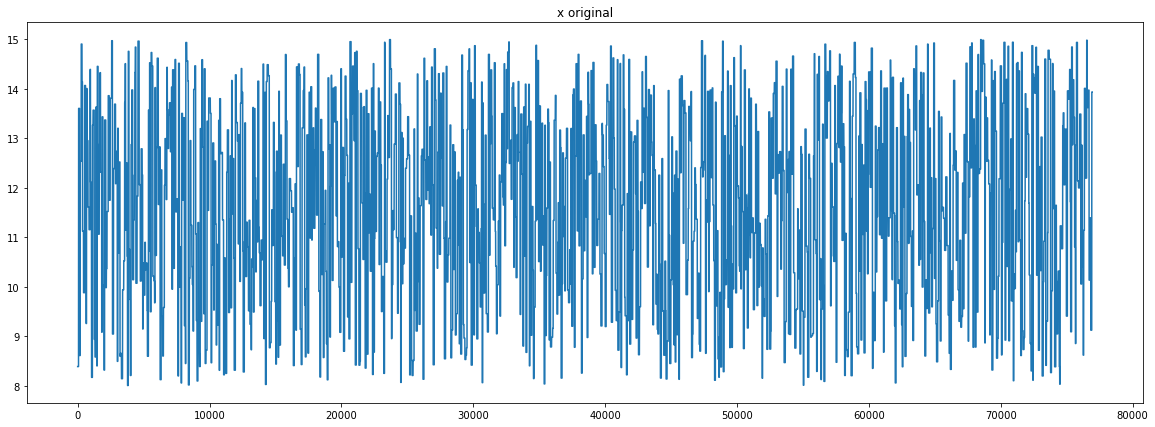

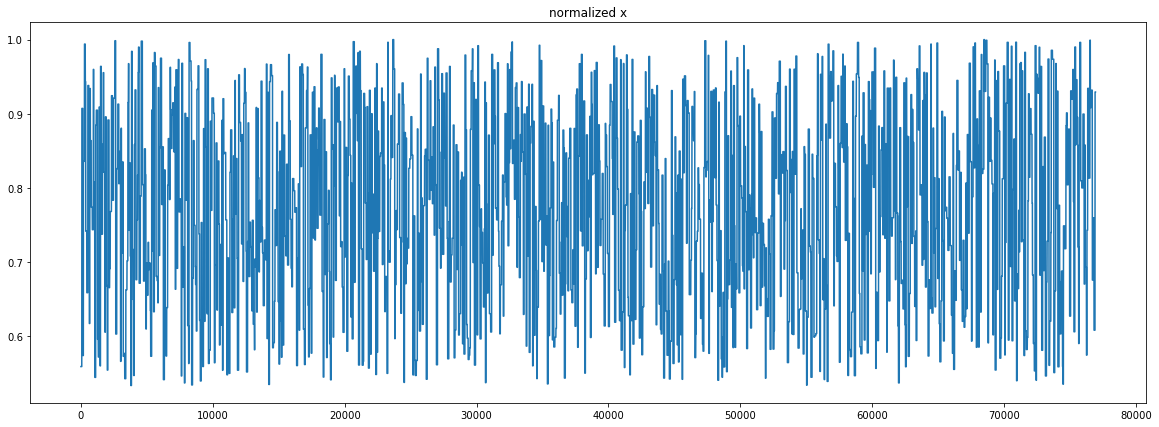

In [37]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x :torch.Size([1024, 128, 1])
y: torch.Size([1024, 3])
y_last: (150,)
x :torch.Size([1024, 128, 1])
y: torch.Size([1024, 3])
y_last: (150,)


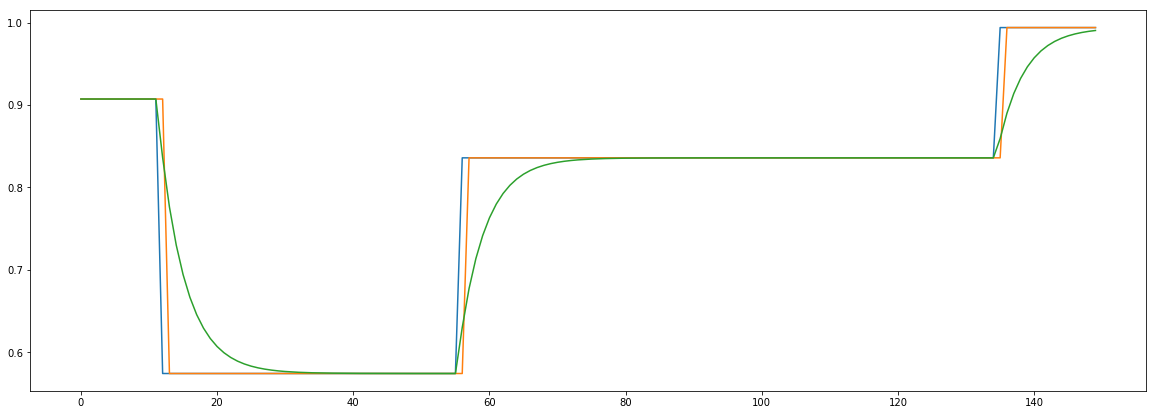

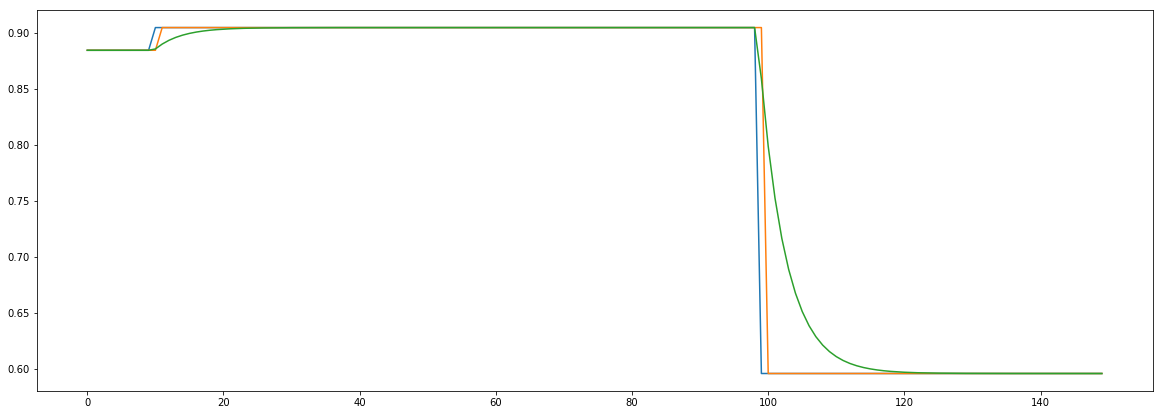

In [38]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x :{x.shape}")
    print(f"y: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t])
    plt.plot(x.detach().numpy()[-2][f:t])
    plt.plot(y_kth)
    plt.show()
    if i == 1:
        break

## Creating objects from imported files

In [39]:
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy  # imports here for faster rerun and debug procedure

model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    optimiser = torch.optim.Adam(model.parameters(), lr=p_train['learning_rate'])

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")


model has [3443.0] params


In [20]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

## Train model

In [40]:
logging.info("History INITIALIZED")

hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        
        "aux":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        
        "const":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        'preds':{
            '1':np.zeros(num_epochs),
            '2':np.zeros(num_epochs),            
        }
       }

In [ ]:
# TODO train function (or trainer class)

In [42]:
logging.info("Training process STARTED")


model.hidden = model.init_hidden()


for t in range(num_epochs):

    for i, data in enumerate(tqdm(train_dl)):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1)
        model.hidden = model.init_hidden()



    # Forward pass
        y_pred = model(x_batch)
        
#         y_pred[:, 0] *= 0
#         y_pred[:, 0] += y_batch[:, 0]
        
        loss = loss_fn(y_pred, y_batch, x_batch, config)
        main_loss, aux_loss, const_loss = loss
        combined_loss = main_loss + aux_loss + const_loss
#         print(loss.shape)
        optimiser.zero_grad()

        # Backward pass
        combined_loss.backward()

        # Update parameters
        optimiser.step()

        hist['train_local_loss'][i] = combined_loss.item()
        hist['const']['train_local_loss'][i] = const_loss.item()
        hist['aux']['train_local_loss'][i] = aux_loss.item() #torch.mean(torch.abs(y_pred[:, 1] - a))



    hist['preds']['1'][t] =torch.mean(y_pred[:, 1]) 
    hist['preds']['2'][t] =torch.mean(y_pred[:, 2]) 



    print(f"aux preds: {torch.mean(y_pred[:, 1])} {torch.mean(y_pred[:, 2])}")
    print(f"aux loss {np.average(hist['aux']['train_local_loss'])}")
    print(f"combined loss {np.average(hist['train_local_loss'])}")

    plot_shared_scale([
        (y_pred[:, 0].detach().numpy(),"Preds" ),
         (y_batch[:, 0].detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ])
    residuals = y_batch[:, 0] - y_pred[:, 0]
    plot_multiscale([
        (residuals.detach().numpy(), "Red"),
        (y_batch[:, 0].detach().numpy(), "Green")
    ]) 

          
    with torch.no_grad():
        model = model.eval()
        for i, data in enumerate(tqdm(train_dl)):
            x_batch, y_batch, indexes = data
            x_batch.transpose_(0, 1)
            y_pred = model(x_batch)
            
            y_pred[:, 0] *= 0
            y_pred[:, 0] += y_batch[:, 0]
            loss = loss_fn(y_pred, y_batch, x_batch, config)
            main_loss, aux_loss, const_loss = loss


            hist['eval_train_local'][i] = main_loss.item()
            hist['const']['eval_train_local'][i] = const_loss.item()
            hist['aux']['eval_train_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred[:, 1] - a) )
        for i, data in enumerate(tqdm(test_dl)):
            x_batch_test, y_batch_test, indexes = data
            x_batch_test.transpose_(0, 1)
            y_pred_test = model(x_batch_test)
            loss = loss_fn(y_pred_test, y_batch_test, x_batch_test, config)
            main_loss, aux_loss, const_loss = loss
            hist['const']['eval_test_local'][i] = const_loss.item()
            hist['eval_test_local'][i] = main_loss.item()
            hist['aux']['eval_test_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred_test[:, 1] - a) )
        model = model.train()


    print("TEST AUX:")
    plot_shared_scale([
            (y_pred_test[:, 1].detach().numpy(),"Preds" ),
            (y_pred_test[:, 2].detach().numpy(),"Preds" ),
    ])
    print("TEST PRED:")
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(),"Preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ])


    residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
    print("TEST RESID:")
    plot_multiscale(
            [
                (residuals.detach().numpy(), "Red"), 
             (y_batch_test[:, 0].detach().numpy(),"Green")
            ])
#     plot_shared_scale( [ (hist["eval_train_local"], "train"),
#                         (hist["eval_test_local"], "test")])
    
          
    logging.info(f"Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_traiDn[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")

                 
    hist["train_loss"][t] = np.average(hist["train_local_loss"])
    hist["eval_train"][t] = np.average(hist["eval_train_local"])
    hist["eval_test"][t] = np.average(hist["eval_test_local"])
    hist['aux']['eval_test'][t] = np.average(hist['aux']['eval_test_local'])
    hist['aux']['eval_train'][t] = np.average(hist['aux']['eval_train_local'])
    hist['aux']['train_loss'][t] = np.average(hist['aux']['train_local_loss'])
    hist['const']['eval_test'][t] = np.average(hist['const']['eval_test_local'])
    hist['const']['eval_train'][t] = np.average(hist['const']['eval_train_local'])
    hist['const']['train_loss'][t] = np.average(hist['const']['train_local_loss'])

#     hist["aux_error"][t] = np.average[]
    print(f" Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")
    logging.info(f" Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")

KeyboardInterrupt: 

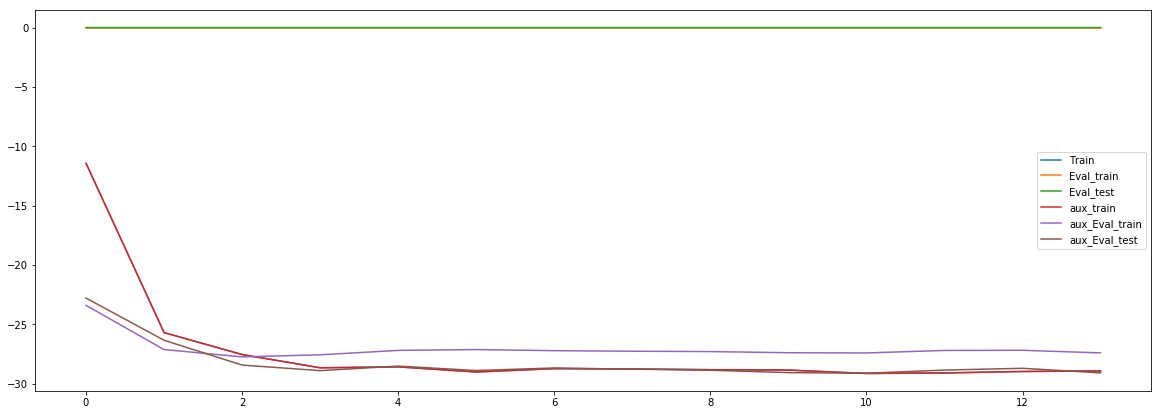

In [30]:
s, e = 0, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [31]:
a = y_batch[:, 0]
a = a.view(a.shape[0], -1)
a.shape


torch.Size([1024, 1])

In [32]:
b = a.t()
b.shape

torch.Size([1, 1024])

In [33]:
c = b.mm(a)
c.shape

torch.Size([1, 1])

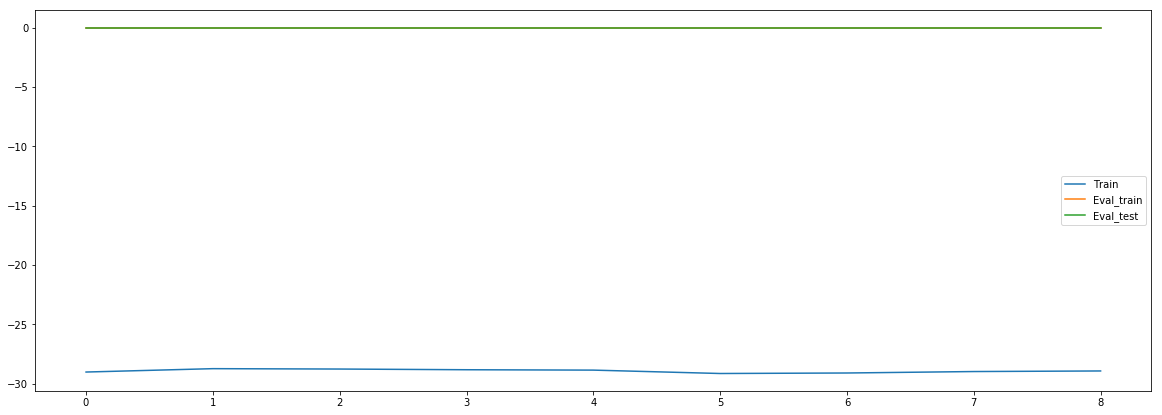

In [34]:
s, e = 5, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
#                   (hist['aux']['train_loss'][s:e], "aux_train"),
#                   (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
#                   (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

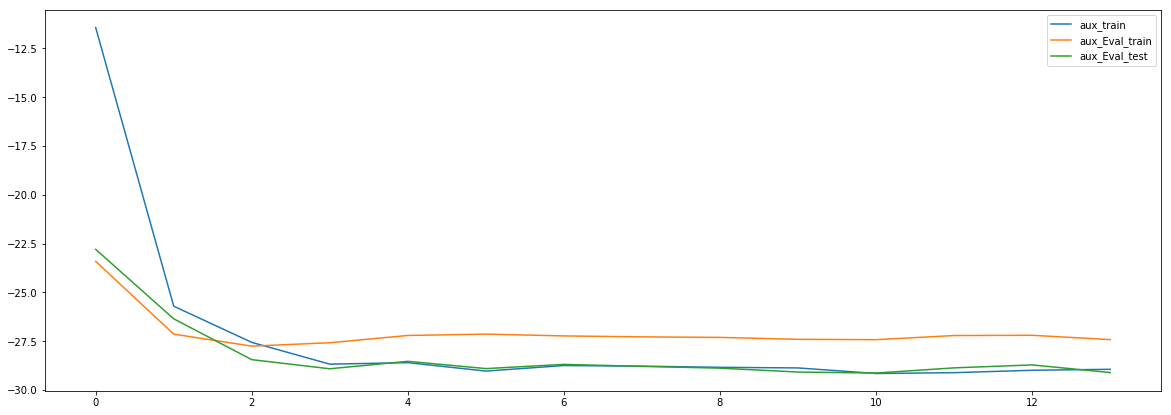

In [35]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")])

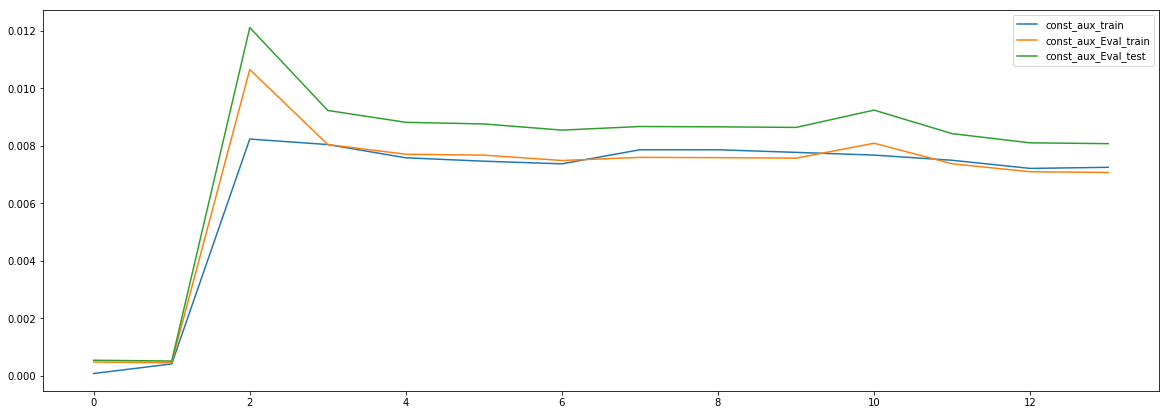

In [36]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['const']['train_loss'][s:e], "const_aux_train"),
                  (hist['const']['eval_train'][s:e], "const_aux_Eval_train"),
                  (hist['const']['eval_test'][s:e], "const_aux_Eval_test")])

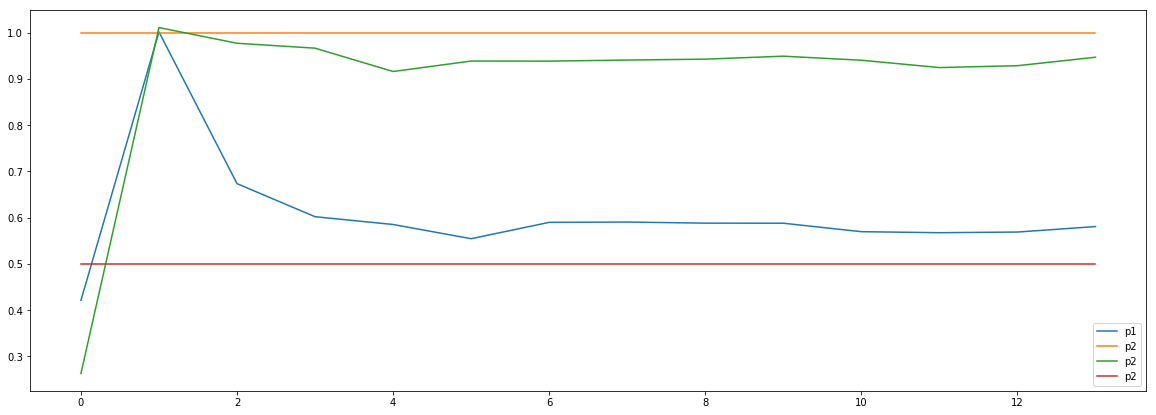

In [37]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['preds']['1'][s:e], "p1"),
                  ((hist['preds']['2']*0 + 1)[s:e], "p2"),
                  (hist['preds']['2'][s:e], "p2"),
                  ((hist['preds']['2']*0 + 0.5)[s:e], "p2"),
#                   (hist['const']['eval_test'][s:e], "const_aux_Eval_test")
])

In [38]:
model.buffers

<bound method Module.buffers of LSTM(
  (lstm): LSTM(1, 16, num_layers=2)
  (linear): Linear(in_features=16, out_features=3, bias=True)
)>

In [ ]:
logging.info("Training process END")

In [ ]:
#